In [3]:
import math

import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from matplotlib.patches import ConnectionPatch
from skimage.feature import SIFT, match_descriptors
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize, ProjectiveTransform, SimilarityTransform, warp
from skimage import measure
import random


#print numpy array without scientific notation
np.set_printoptions(suppress=True)

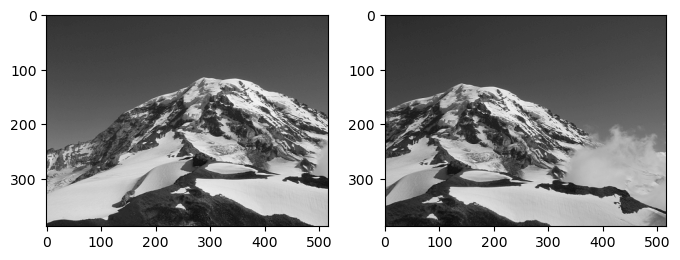

In [4]:
dst_img_rgb = np.asarray(Image.open('data/Rainier1.png'))
src_img_rgb = np.asarray(Image.open('data/Rainier2.png'))

if dst_img_rgb.shape[2] == 4:
    dst_img_rgb = rgba2rgb(dst_img_rgb)
if src_img_rgb.shape[2] == 4:
    src_img_rgb = rgba2rgb(src_img_rgb)

dst_img = rgb2gray(dst_img_rgb)
src_img = rgb2gray(src_img_rgb)

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(dst_img, cmap='gray')
ax2.imshow(src_img, cmap='gray')

In [5]:
detector1 = SIFT()
detector2 = SIFT()
detector1.detect_and_extract(dst_img)
detector2.detect_and_extract(src_img)
keypoints1 = detector1.keypoints
descriptors1 = detector1.descriptors
keypoints2 = detector2.keypoints
descriptors2 = detector2.descriptors

In [6]:
matches = match_descriptors(descriptors1, descriptors2, cross_check=True)
print(matches.shape)

(618, 2)


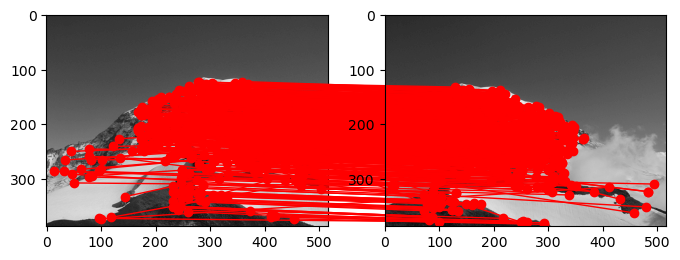

In [7]:
# Select the points in img1 that match with img2 and vice versa
dst = keypoints1[matches[:, 0]]
src = keypoints2[matches[:, 1]]

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(dst_img, cmap='gray')
ax2.imshow(src_img, cmap='gray')

for i in range(src.shape[0]):
    coordB = [dst[i, 1], dst[i, 0]]
    coordA = [src[i, 1], src[i, 0]]
    con = ConnectionPatch(xyA=coordA, xyB=coordB, coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax1, color="red")
    ax2.add_artist(con)
    ax1.plot(dst[i, 1], dst[i, 0], 'ro')
    ax2.plot(src[i, 1], src[i, 0], 'ro')

In [8]:
sk_M, sk_best = measure.ransac((src[:, ::-1], dst[:, ::-1]), ProjectiveTransform, min_samples=4, residual_threshold=1, max_trials=300)
print(sk_M)
print(sk_best.shape)
print(matches.shape)

<ProjectiveTransform(matrix=
    [[  0.79750341,   0.03997054, 156.31590713],
     [ -0.10854782,   0.93417259,   6.4146929 ],
     [ -0.00041145,   0.00003064,   1.        ]])>
(618,)
(618, 2)


427


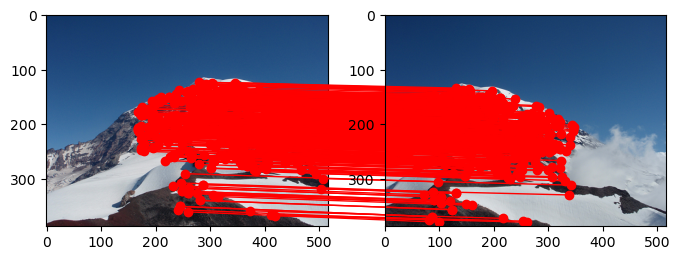

In [9]:
print(np.count_nonzero(sk_best))
src_best = keypoints2[matches[sk_best, 1]][:, ::-1]
dst_best = keypoints1[matches[sk_best, 0]][:, ::-1]

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(dst_img_rgb)
ax2.imshow(src_img_rgb)

for i in range(src_best.shape[0]):
    coordB = [dst_best[i, 0], dst_best[i, 1]]
    coordA = [src_best[i, 0], src_best[i, 1]]
    con = ConnectionPatch(xyA=coordA, xyB=coordB, coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax1, color="red")
    ax2.add_artist(con)
    ax1.plot(dst_best[i, 0], dst_best[i, 1], 'ro')
    ax2.plot(src_best[i, 0], src_best[i, 1], 'ro')

In [10]:
# note that kp1 is the keypoint from the source image
# and kp2 is their coresponding match point
def compute_affine_transform(kp1, kp2):
    ones = np.ones((kp1.shape[0], 1))
    kp1 = np.concatenate((kp1, ones), axis=1)
    # init matrix A
    A = np.zeros((2*kp1.shape[0], 6))
    for i in range(0,len(A),2):
        A[i] = np.concatenate((kp1[i//2], np.array([0,0,0])))
        A[i+1] = np.concatenate((np.array([0,0,0]), kp1[i//2]))
    
    b = np.reshape(kp2, -1)
    x = ((np.linalg.inv(((A.T).dot(A)))).dot(A.T)).dot(b)
    x = np.concatenate((x, [0,0,1]))
    x = np.reshape(x, (3,3))
    return x
    
affine_matrix = compute_affine_transform(src, dst)
#print(affine_matrix)
#print(affine_matrix.dot([1,8,1]))

In [11]:
def compute_projective_transform(kp1, kp2):
    # Convert points to homogeneous coordinates
    kp1 = np.hstack([np.array(kp1), np.ones((len(kp1), 1))])
    
    # Solve for the projective transform matrix (homography) using linear least squares
    A = []
    for i in range(len(kp1)):
        x, y, z = kp1[i]
        u, v    = kp2[i]
        A.append([x, y, 1, 0, 0, 0, -x*u, -y*u])
        A.append([0, 0, 0, x, y, 1, -x*v, -y*v])
    A = np.array(A)
    b = np.reshape(kp2, -1)
    x = ((np.linalg.inv(((A.T).dot(A)))).dot(A.T)).dot(b)
    x = np.concatenate((x, [1]))
    x = np.reshape(x, (3,3))
    return x
projective_matrix = compute_projective_transform(src, dst)
#print(projective_matrix)

In [14]:
def ransac(source_kp, dest_kp, max_iteration, min_samples, thresh, matrix_type="affine"):
    best_inliers = []
    best_score = 0
    
    for i in range(max_iteration):
        # Select a random subset of keypoints
        sample_indices = random.sample(range(len(source_kp)), min_samples)
        source_sample = [source_kp[idx] for idx in sample_indices]
        dest_sample = [dest_kp[idx] for idx in sample_indices]
        source_sample = np.array(source_sample)
        dest_sample = np.array(dest_sample)
        
        # Compute the transformation matrix using the sample
        if matrix_type == "affine":
            H = compute_affine_transform(source_sample, dest_sample)
        else:
            H = compute_projective_transform(source_sample, dest_sample)
        
        # Apply the transformation to the source keypoints
        # transformed_pts aka predicted distination keypoints
        transformed_pts = apply_transform_matrix(source_kp, H, matrix_type)
        
        # Count the number of inliers (keypoints with distances less than the threshold)
        inliers = []
        for j in range(len(dest_kp)):
            if np.linalg.norm(transformed_pts[j] - dest_kp[j]) < thresh:
                inliers.append(j)
        score = len(inliers)
        
        if score > best_score:
            # Update the best_inliers if found a better one
            best_score = score
            best_inliers = inliers
            
    return best_inliers

def apply_transform_matrix(points, H, matrix_type):
    """Apply transform matrix to a set of 2D points"""
    points = np.array(points)
    ones = np.ones((points.shape[0], 1))
    points = np.hstack([points, ones])

    transformed_pts = []
    for point in points:
        #it is possible to get a negative value over here, remember this is feature point of different images
        transformed_point = H.dot(point)
        if matrix_type == "affine":
            transformed_pts.append(transformed_point[0:2])
        else:
            transformed_pts.append(transformed_point[0:2]/transformed_point[2])
    return np.array(transformed_pts)

best_matching_kp_idx = ransac(src, dst, 300, 4, 2, "affine")
# print(source.shape)
# print(best_matching_kp_idx)
print(len(best_matching_kp_idx))

236


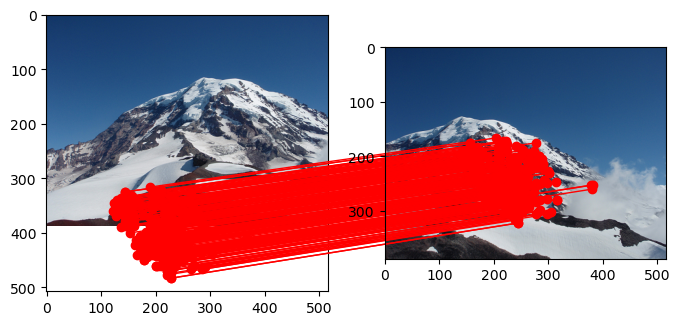

In [15]:
def plot_matching_ransac(img1, img2, source_kp, dest_kp, matching_list):
    source_best = np.array([source_kp[i] for i in matching_list])
    dest_best = np.array([dest_kp[i] for i in matching_list])
#     print(source_best.shape)
#     print(dest_best.shape)
    
    fig = plt.figure(figsize=(8, 4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.imshow(img2)
    ax2.imshow(img1)

    for i in range(source_best.shape[0]):
        coordB = [dest_best[i, 0], dest_best[i, 1]]
        coordA = [source_best[i, 0], source_best[i, 1]]
        con = ConnectionPatch(xyA=coordA, xyB=coordB, coordsA="data", coordsB="data",
                              axesA=ax2, axesB=ax1, color="red")
        ax2.add_artist(con)
        ax1.plot(dest_best[i, 0], dest_best[i, 1], 'ro')
        ax2.plot(source_best[i, 0], source_best[i, 1], 'ro')

plot_matching_ransac(src_img_rgb, dst_img_rgb, src, dst, best_matching_kp_idx)